# 推荐系统

### 1、如何给用户推荐标签


    当用户u给物品i打标签时，可以给用户推荐和物品i相关的标签，方法如下：
    
    方法1：给用户u推荐整个系统最热门的标签
    
    方法2：给用户u推荐物品i上最热门的标签
    
    方法3：给用户u推荐他自己经常使用的标签
    
    将方法2和3进行加权融合，生成最终的标签推荐结果


#### 基于内容的推荐系统架构

    物品表示 Item Representation：为每个item抽取出features
    
    特征学习Profile Learning：利用一个用户过去喜欢（不喜欢）的item的特征数据，来学习该用户的喜好特征（profile）；
    
    生成推荐列表Recommendation Generation：通过用户profile与候选item的特征，推荐相关性最大的item。 
    
    标签可以作为用户的画像Profile，也可以作为Item的特征
    
    User=>Item之间的匹配程度：SimpleTagBased、NormTagBased、TagBased-TFIDF


### 算法
    基于标签推荐：SimpleTagBased，NormTagBased，TagBased-TFIDF
    
    基于内容的推荐
    
    基于协同过滤：User-CF, Item-CF
    
    CTR预估：GBDT+LR, Wide & Deep, FM, FFM, DeepFM, NFM, Deep & Cross, xDeepFM, DIN, DIEN, DSIN


#### SimpleTagBased算法

    统计每个用户的常用标签

    对每个标签，统计被打过这个标签次数最多的商品

    对于一个用户，找到他常用的标签，然后找到具有这些标签的最热门物品推荐给他
    
    用户u对商品i的兴趣  score = 用户u使用过标签t的次数 * 商品i被打过标签次数
   
    可能存在问题：热门标签权重太大

![Image of Yaktocat](img/2.png)

    数据结构定义：
    
    用户打标签记录：records[i] = {user, item, tag}
    
    用户打过的标签：user_tags[u][t] 
    
    用户打过标签的商品：user_items[u][i]
    
    打上某标签的商品：tag_items[t][i]
    
    某标签使用过的用户：tags_users[t][u]


#### NormTagBased算法：

    SimpleTagBased算法的改进，对热门标签降权，对score进行归一化，使用比值相对客观些

![Image of Yaktocat](img/4.png)

#### TagBased-TFIDF算法：
     SimpleTagBased算法的改进

    如果一个tag很热门，会导致user_tags[t]很大，所以即使tag_items[u,t]很小，也会导致score(u,i)很大。给热门标签过大的权重，不能反应用户个性化的兴趣
    
    这里借鉴TF-IDF的思想，对文章标签过大的权重做降权处理，对使用tag_users[t]表示标签t被多少个不同的用户使用

![Image of Yaktocat](img/5.png)

In [3]:
# 使用SimpleTagBased算法对Delicious2K数据进行推荐
# 原始数据集：https://grouplens.org/datasets/hetrec-2011/
# 数据格式：userID     bookmarkID     tagID     timestamp
import random
import math
import operator
import pandas as pd

file_path = "data/user_taggedbookmarks-timestamps.dat"
# 字典类型，保存了user对item的tag，即{userid: {item1:[tag1, tag2], ...}}
records = {}
# 训练集，测试集
train_data = dict()
test_data = dict()
# 用户标签，商品标签
user_tags = dict()
tag_items = dict()
user_items = dict()

# 使用测试集，计算准确率和召回率
def precisionAndRecall(N):
    hit = 0
    h_recall = 0
    h_precision = 0
    for user,items in test_data.items():
        if user not in train_data:
            continue
        # 获取Top-N推荐列表
        rank = recommend(user, N)
        for item,rui in rank:
            if item in items:
                hit = hit + 1
        h_recall = h_recall + len(items)
        h_precision = h_precision + N
    #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
    # 返回准确率 和 召回率
    return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))

# 对用户user推荐Top-N
def recommend(user, N):
    recommend_items=dict()
    # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
    tagged_items = user_items[user]     
    for tag, wut in user_tags[user].items():
        #print(self.user_tags[user].items())
        for item, wti in tag_items[tag].items():
            if item in tagged_items:
                continue
            #print('wut = %s, wti = %s' %(wut, wti))
            if item not in recommend_items:
                recommend_items[item] = wut * wti
            else:
                recommend_items[item] = recommend_items[item] + wut * wti
    return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]

# 使用测试集，对推荐结果进行评估
def testRecommend():
    print("推荐结果评估")
    print("%3s %10s %10s" % ('N',"精确率",'召回率'))
    for n in [5,10,20,40,60,80,100]:
        precision,recall = precisionAndRecall(n)
        print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
        
# 数据加载
def load_data():
    print("开始数据加载...")
    df = pd.read_csv(file_path, sep='\t')
    for i in range(len(df)):
        uid = df['userID'][i]
        iid = df['bookmarkID'][i]
        tag = df['tagID'][i]
        # 键不存在时，设置默认值{}
        records.setdefault(uid,{})
        records[uid].setdefault(iid,[])
        records[uid][iid].append(tag)
    print("数据集大小为 %d." % (len(df)))
    print("设置tag的人数 %d." % (len(records)))
    print("数据加载完成\n")

# 将数据集拆分为训练集和测试集
def train_test_split(ratio, seed=100):
    random.seed(seed)
    for u in records.keys():
        for i in records[u].keys():
            # ratio比例设置为测试集
            if random.random()<ratio:
                test_data.setdefault(u,{})
                test_data[u].setdefault(i,[])
                for t in records[u][i]:
                    test_data[u][i].append(t)
            else:
                train_data.setdefault(u,{})
                train_data[u].setdefault(i,[])
                for t in records[u][i]:
                    train_data[u][i].append(t)        
    print("训练集样本数 %d, 测试集样本数 %d" % (len(train_data),len(test_data)))

# 设置矩阵 mat[index, item] = 1
def addValueToMat(mat, index, item, value=1):
    if index not in mat:
        mat.setdefault(index,{})
        mat[index].setdefault(item,value)
    else:
        if item not in mat[index]:
            mat[index][item] = value
        else:
            mat[index][item] += value


# 使用训练集，初始化user_tags, tag_items, user_items
def initStat():
    records=train_data
    for u,items in records.items():
        for i,tags in items.items():
            for tag in tags:
                #print tag
                # 用户和tag的关系
                addValueToMat(user_tags, u, tag, 1)
                # tag和item的关系
                addValueToMat(tag_items, tag, i, 1)
                # 用户和item的关系
                addValueToMat(user_items, u, i, 1)
    print("user_tags, tag_items, user_items初始化完成.")
    print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d" % (len(user_tags), len(tag_items), len(user_items)))

# 数据加载
load_data()
# 训练集，测试集拆分，20%测试集
train_test_split(0.2)
initStat()
testRecommend()


开始数据加载...
数据集大小为 437593.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860
推荐结果评估
  N        精确率        召回率
  5      0.829%      0.355%
 10      0.633%      0.542%
 20      0.512%      0.877%
 40      0.381%      1.304%
 60      0.318%      1.635%
 80      0.276%      1.893%
100      0.248%      2.124%


### 2、基于内容的推荐


    依赖性低，不需要动态的用户行为，只要有内容就可以进行推荐
    系统不同阶段都可以应用
    系统冷启动，内容是任何系统天生的属性，可以从中挖掘到特征，实现推荐系统的冷启动。一个复杂的推荐系统是从基于内容的推荐成长起来的
    商品冷启动，不论什么阶段，总会有新的物品加入，这时只要有内容信息，就可以帮它进行推荐

    物品表示 Item Representation：
    为每个item抽取出features
    特征学习Profile Learning：
    利用一个用户过去喜欢（不喜欢）的item的特征数据，来学习该用户的喜好特征（profile）；
    生成推荐列表Recommendation Generation：
    通过用户profile与候选item的特征，推荐相关性最大的item。 


#### 为酒店建立内容推荐系统


    西雅图酒店数据集：
    下载地址：https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Seattle_Hotels.csv
    字段：name, address, desc
    基于用户选择的酒店，推荐相似度高的Top10个其他酒店
    方法：计算当前酒店特征向量与整个酒店特征矩阵的余弦相似度，取相似度最大的Top-k个

数据集中酒店的个数： 152


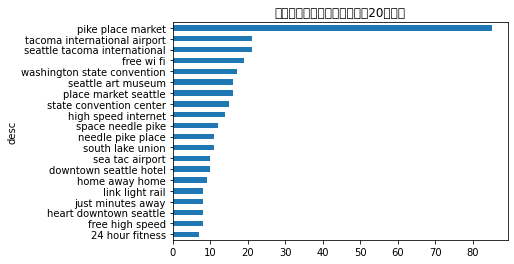

In [94]:

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
df = pd.read_csv('data/Seattle_Hotels.csv')
# print(df.head())
print('数据集中酒店的个数：',len(df))

def print_description(index):
    
    example = df[df.index == index][['desc','name']].values[0]
    if len(example)>0:
        print(example[0])
        print('Name:',example[1])
# print('第10个酒店的描述：')
# print_description(10)

# 得到酒店描述中n-gram特征中的topk个
def get_top_words(corpus, n=1, k=None):
    # 统计ngram词频矩阵
    vec = CountVectorizer(ngram_range=(n,n), stop_words="english").fit(corpus)
    bg_of_words = vec.transform(corpus)
    sum_words = bg_of_words.sum(axis=0)
#     print('feature_names:')
#     print(vec.get_feature_names())
#     ptint('bag of words:')
#     print(bg_of_words.toarray())
    words_freq = [(word,sum_words[0, freq]) for word, freq in vec.vocabulary_.items()]
    # 按照词频从大到小排序
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse=True)
    return words_freq[:k]

common_words = get_top_words(df['desc'], 3, 20)
df1 = pd.DataFrame(common_words,columns=['desc','count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh',title="去掉停用词后，酒店描述中前20的单词")
plt.show()


In [95]:
# 文本预处理
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# 从nltk中加载停用词
# 英语停用词，引入停用词文件,这里只是列一些简单的停用词
STOPWORDS = ['a','an','is','of','on','in','the',"what"]

# 对文本进行清洗
def clean_text(text):
    # 转为小写
    text = text.lower()
    # 用空格代替一些特殊字符
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
   
    # 移除BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('', text)
    # 从文本中去掉停用词语
    return ' '.join(word for word in text.split() if word not in STOPWORDS)

# 对desc字段进行清理
df['desc_clean'] = df['desc'].apply(clean_text)
df

,name,address,desc,desc_clean
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the...",located southern tip lake union hilton garden ...
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat...",located citys vibrant core sheraton grand seat...
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ...",located heart downtown seattle awardwinningcro...
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...,whats near our hotel downtown seattle location...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...,situated amid incredible shopping and iconic a...
...,...,...,...,...
147,The Halcyon Suite Du Jour,"1125 9th Ave W, Seattle, WA 98119","Located in Queen Anne district, The Halcyon Su...",located queen anne district halcyon suite du j...
148,Vermont Inn,"2721 4th Ave, Seattle, WA 98121",Just a block from the world famous Space Needl...,just block from world famous space needle and ...
149,Stay Alfred on Wall Street,"2515 4th Ave, Seattle, WA 98121",Stay Alfred on Wall Street resides in the hear...,stay alfred wall street resides heart belltown...
150,Pike's Place Lux Suites by Barsala,"2nd Ave and Stewart St, Seattle, WA 98101",The perfect marriage of heightened convenience...,perfect marriage heightened convenience and un...


In [96]:
# 使用TF-IDF提取特征
df.set_index('name', inplace = True)
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3),min_df=0.01,stop_words="english")
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('TFIDF feature names:')
print(len(tf.get_feature_names()))

# 计算酒店之间的cos（线性核函数）
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index) # 酒店名称
# 基于相似度矩阵核制定酒店的名称name，推荐TOP10的酒店
def recommendation(name, consine_similarties = cosine_similarities):
    recommended_hotels = []
    # 找到想要查询酒店的名称idx
    idx = indices[indices == name].index[0]
    # 对于idx酒店的余弦相似度向量按照从大到小的顺序排列
    score_series = pd.Series(consine_similarties[idx]).sort_values(ascending = False) 
    # 取出相似度最大的前10个（除自己以外）
    top_10_indexs = list(score_series.iloc[1:11].index)
    # 放入推荐列表
    return [list(df.index)[i] for i in top_10_indexs]

print(recommendation('Hilton Garden Seattle Downtown'))

TFIDF feature names:
3165
['Silver Cloud Inn - Seattle Lake Union', 'Staybridge Suites Seattle Downtown - Lake Union', 'The Charter Hotel Seattle, Curio Collection by Hilton', 'The Loyal Inn', 'Residence Inn by Marriott Seattle Downtown/Lake Union', 'MarQueen Hotel', 'The Arctic Club Seattle - a DoubleTree by Hilton Hotel', 'SpringHill Suites Seattle\xa0Downtown', 'Embassy Suites by Hilton Seattle Tacoma International Airport', 'Moxy Seattle Downtown']


### 3、基于协同过滤的推荐

## 推荐系统的两大应用场景
    评分预测（Rating Prediction）
    主要用于评价网站，比如用户给自己看过的电影评多少分（MovieLens），或者用户给自己看过的书籍评价多少分（Douban）。矩阵分解技术主要应用于评分预测问题。

    Top-N推荐（Item Ranking）
    常用于购物网站，拿不到显式评分，通过用户的隐式反馈为用户提供一个可能感兴趣的Item列表。排序任务，需要排序模型进行建模

#### 1、矩阵分解——评分预测

##### Project A：对Movelens进行电影推荐



    数据集：MovieLens
    
    下载地址：https://www.kaggle.com/jneupane12/movielens/download
    
    主要使用的文件：ratings.csv
    
    格式：userId, movieId, rating, timestamp
    
    记录了用户在某个时间对某个movieId的打分情况
    
    我们需要补全评分矩阵，然后对指定用户，比如userID为1-5进行预测

In [8]:
# 使用ALS进行矩阵分解
from itertools import product, chain
from copy import deepcopy


class Matrix(object):
    def __init__(self, data):
        self.data = data
        self.shape = (len(data), len(data[0]))

    def row(self, row_no):
        """Get a row of the matrix.
        Arguments:
            row_no {int} -- Row number of the matrix.
        Returns:
            Matrix
        """

        return Matrix([self.data[row_no]])

    def col(self, col_no):
        """Get a column of the matrix.
        Arguments:
            col_no {int} -- Column number of the matrix.
        Returns:
            Matrix
        """
        m = self.shape[0]
        return Matrix([[self.data[i][col_no]] for i in range(m)])

    @property
    def is_square(self):
        """Check if the matrix is a square matrix.
        Returns:
            bool
        """

        return self.shape[0] == self.shape[1]

    @property
    def transpose(self):
        """Find the transpose of the original matrix.
        Returns:
            Matrix
        """

        data = list(map(list, zip(*self.data)))
        return Matrix(data)

    def _eye(self, n):
        """Get a unit matrix with shape (n, n).
        Arguments:
            n {int} -- Rank of unit matrix.
        Returns:
            list
        """

        return [[0 if i != j else 1 for j in range(n)] for i in range(n)]

    @property
    def eye(self):
        """Get a unit matrix with the same shape of self.
        Returns:
            Matrix
        """

        assert self.is_square, "The matrix has to be square!"
        data = self._eye(self.shape[0])
        return Matrix(data)

    def _gaussian_elimination(self, aug_matrix):
        """To simplify the left square matrix of the augmented matrix
        as a unit diagonal matrix.
        Arguments:
            aug_matrix {list} -- 2d list with int or float.
        Returns:
            list -- 2d list with int or float.
        """

        n = len(aug_matrix)
        m = len(aug_matrix[0])

        # From top to bottom.
        for col_idx in range(n):
            # Check if element on the diagonal is zero.
            if aug_matrix[col_idx][col_idx] == 0:
                row_idx = col_idx
                # Find a row whose element has same column index with
                # the element on the diagonal is not zero.
                while row_idx < n and aug_matrix[row_idx][col_idx] == 0:
                    row_idx += 1
                # Add this row to the row of the element on the diagonal.
                for i in range(col_idx, m):
                    aug_matrix[col_idx][i] += aug_matrix[row_idx][i]

            # Elimiate the non-zero element.
            for i in range(col_idx + 1, n):
                # Skip the zero element.
                if aug_matrix[i][col_idx] == 0:
                    continue
                # Elimiate the non-zero element.
                k = aug_matrix[i][col_idx] / aug_matrix[col_idx][col_idx]
                for j in range(col_idx, m):
                    aug_matrix[i][j] -= k * aug_matrix[col_idx][j]

        # From bottom to top.
        for col_idx in range(n - 1, -1, -1):
            # Elimiate the non-zero element.
            for i in range(col_idx):
                # Skip the zero element.
                if aug_matrix[i][col_idx] == 0:
                    continue
                # Elimiate the non-zero element.
                k = aug_matrix[i][col_idx] / aug_matrix[col_idx][col_idx]
                for j in chain(range(i, col_idx + 1), range(n, m)):
                    aug_matrix[i][j] -= k * aug_matrix[col_idx][j]

        # Iterate the element on the diagonal.
        for i in range(n):
            k = 1 / aug_matrix[i][i]
            aug_matrix[i][i] *= k
            for j in range(n, m):
                aug_matrix[i][j] *= k

        return aug_matrix

    def _inverse(self, data):
        """Find the inverse of a matrix.
        Arguments:
            data {list} -- 2d list with int or float.
        Returns:
            list -- 2d list with int or float.
        """

        n = len(data)
        unit_matrix = self._eye(n)
        aug_matrix = [a + b for a, b in zip(self.data, unit_matrix)]
        ret = self._gaussian_elimination(aug_matrix)
        return list(map(lambda x: x[n:], ret))

    @property
    def inverse(self):
        """Find the inverse matrix of self.
        Returns:
            Matrix
        """

        assert self.is_square, "The matrix has to be square!"
        data = self._inverse(self.data)
        return Matrix(data)

    def _row_mul(self, row_A, row_B):
        """Multiply the elements with the same subscript in both arrays and sum them.
        Arguments:
            row_A {list} -- 1d list with float or int.
            row_B {list} -- 1d list with float or int.
        Returns:
            float or int
        """

        return sum(x[0] * x[1] for x in zip(row_A, row_B))

    def _mat_mul(self, row_A, B):
        """An auxiliary function of the mat_mul function.
        Arguments:
            row_A {list} -- 1d list with float or int.
            B {Matrix}
        Returns:
            list -- 1d list with float or int.
        """

        row_pairs = product([row_A], B.transpose.data)
        return [self._row_mul(*row_pair) for row_pair in row_pairs]

    def mat_mul(self, B):
        """Matrix multiplication.
        Arguments:
            B {Matrix}
        Returns:
            Matrix
        """

        error_msg = "A's column count does not match B's row count!"
        assert self.shape[1] == B.shape[0], error_msg
        return Matrix([self._mat_mul(row_A, B) for row_A in self.data])

    def _mean(self, data):
        """Calculate the average of all the samples.
        Arguments:
            X {list} -- 2d list with int or float.
        Returns:
            list -- 1d list with int or float.
        """

        m = len(data)
        n = len(data[0])
        ret = [0 for _ in range(n)]
        for row in data:
            for j in range(n):
                ret[j] += row[j] / m
        return ret

    def mean(self):
        """Calculate the average of all the samples.
        Returns:
            Matrix
        """

        return Matrix(self._mean(self.data))

    def scala_mul(self, scala):
        """Scala multiplication.
        Arguments:
            scala {float}
        Returns:
            Matrix
        """

        m, n = self.shape
        data = deepcopy(self.data)
        for i in range(m):
            for j in range(n):
                data[i][j] *= scala
        return Matrix(data)


import pandas as pd
import numpy as np
import random
from collections import defaultdict

class ALS(object):
    def __init__(self):
        self.user_ids = None
        self.item_ids = None
        self.user_ids_dict = None
        self.item_ids_dict = None
        self.user_matrix = None
        self.item_matrix = None
        self.user_items = None
        self.shape = None
        self.rmse = None


    def _process_data(self, X):
        """ 将评分矩阵X转化为稀疏矩阵
            输入参数X:
                X {list} -- 2d list with int or float(user_id, item_id, rating)
            输出结果:
                dict -- {user_id: {item_id: rating}}
                dict -- {item_id: {user_id: rating}}
        """        
        self.user_ids = tuple((set(map(lambda x: x[0], X))))
        self.user_ids_dict = dict(map(lambda x: x[::-1], enumerate(self.user_ids)))
     
        self.item_ids = tuple((set(map(lambda x: x[1], X))))
        self.item_ids_dict = dict(map(lambda x: x[::-1], enumerate(self.item_ids)))
     
        self.shape = (len(self.user_ids), len(self.item_ids))
     
        ratings = defaultdict(lambda: defaultdict(int))
        ratings_T = defaultdict(lambda: defaultdict(int))
        for row in X:
            user_id, item_id, rating = row
            ratings[user_id][item_id] = rating
            ratings_T[item_id][user_id] = rating
     
        err_msg = "Length of user_ids %d and ratings %d not match!" % (len(self.user_ids), len(ratings))
        assert len(self.user_ids) == len(ratings), err_msg
     
        err_msg = "Length of item_ids %d and ratings_T %d not match!" % (len(self.item_ids), len(ratings_T))
        assert len(self.item_ids) == len(ratings_T), err_msg
        return ratings, ratings_T

     
    def _users_mul_ratings(self, users, ratings_T):
        """ 用户矩阵(稠密) 与 评分矩阵（稀疏）相乘
            The result(items) is a k * n matrix, n stands for number of item_ids.
            Arguments:
                users {Matrix} -- k * m matrix, m stands for number of user_ids.
                ratings_T {dict} -- The items ratings by users.
                {item_id: {user_id: rating}}
            Returns:
                Matrix -- Item matrix.
        """
        def f(users_row, item_id):
            user_ids = iter(ratings_T[item_id].keys())
            scores = iter(ratings_T[item_id].values())
            col_nos = map(lambda x: self.user_ids_dict[x], user_ids)
            _users_row = map(lambda x: users_row[x], col_nos)
            return sum(a * b for a, b in zip(_users_row, scores))
     
        ret = [[f(users_row, item_id) for item_id in self.item_ids] for users_row in users.data]
        return Matrix(ret)

    def _items_mul_ratings(self, items, ratings):
        """ item矩阵（稠密）与评分矩阵（稀疏）相乘
        The result(users) is a k * m matrix, m stands for number of user_ids.
        Arguments:
            items {Matrix} -- k * n matrix, n stands for number of item_ids.
            ratings {dict} -- The items ratings by users.
            {user_id: {item_id: rating}}
        Returns:
            Matrix -- User matrix.
        """
        def f(items_row, user_id):
            item_ids = iter(ratings[user_id].keys())
            scores = iter(ratings[user_id].values())
            col_nos = map(lambda x: self.item_ids_dict[x], item_ids)
            _items_row = map(lambda x: items_row[x], col_nos)
            return sum(a * b for a, b in zip(_items_row, scores))
     
        ret = [[f(items_row, user_id) for user_id in self.user_ids] for items_row in items.data]
        return Matrix(ret)

    # 生成随机矩阵
    def _gen_random_matrix(self, n_rows, n_colums):
        #print(n_colums, ' ', n_rows)
        #data = [[random() for _ in range(n_colums)] for _ in range(n_rows)]
        #d = 2
        data = np.random.rand(n_rows, n_colums)
        return Matrix(data)


    # 计算RMSE
    def _get_rmse(self, ratings):
            m, n = self.shape
            mse = 0.0
            n_elements = sum(map(len, ratings.values()))
            for i in range(m):
                for j in range(n):
                    user_id = self.user_ids[i]
                    item_id = self.item_ids[j]
                    rating = ratings[user_id][item_id]
                    if rating > 0:
                        user_row = self.user_matrix.col(i).transpose
                        item_col = self.item_matrix.col(j)
                        rating_hat = user_row.mat_mul(item_col).data[0][0]
                        square_error = (rating - rating_hat) ** 2
                        mse += square_error / n_elements
            return mse ** 0.5

    # 模型训练
    def fit(self, X, k, max_iter=10):
        ratings, ratings_T = self._process_data(X)
        self.user_items = {k: set(v.keys()) for k, v in ratings.items()}
        m, n = self.shape
     
        error_msg = "Parameter k must be less than the rank of original matrix"
        assert k < min(m, n), error_msg
     
        self.user_matrix = self._gen_random_matrix(k, m)
     
        for i in range(max_iter):
            if i % 2:
                items = self.item_matrix
                self.user_matrix = self._items_mul_ratings(
                    items.mat_mul(items.transpose).inverse.mat_mul(items),
                    ratings
                )
            else:
                users = self.user_matrix
                self.item_matrix = self._users_mul_ratings(
                    users.mat_mul(users.transpose).inverse.mat_mul(users),
                    ratings_T
                )
            rmse = self._get_rmse(ratings)
            print("Iterations: %d, RMSE: %.6f" % (i + 1, rmse))
     
        self.rmse = rmse

    # Top-n推荐，用户列表：user_id, n_items: Top-n
    def _predict(self, user_id, n_items):
        users_col = self.user_matrix.col(self.user_ids_dict[user_id])
        users_col = users_col.transpose
     
        items_col = enumerate(users_col.mat_mul(self.item_matrix).data[0])
        items_scores = map(lambda x: (self.item_ids[x[0]], x[1]), items_col)
        viewed_items = self.user_items[user_id]
        items_scores = filter(lambda x: x[0] not in viewed_items, items_scores)
     
        return sorted(items_scores, key=lambda x: x[1], reverse=True)[:n_items]

    # 预测多个用户
    def predict(self, user_ids, n_items=10):
        return [self._predict(user_id, n_items) for user_id in user_ids]

def format_prediction(item_id, score):
    return "item_id:%d score:%.2f" % (item_id, score)

def load_movie_ratings(file_name):
    f = open(file_name)
    lines = iter(f)
    col_names = ", ".join(next(lines)[:-1].split(",")[:-1])
    print("The column names are: %s." % col_names)
    data = [[float(x) if i == 2 else int(x)
             for i, x in enumerate(line[:-1].split(",")[:-1])]
            for line in lines]
    f.close()

    return data

print("使用ALS算法") 
model = ALS()
# 数据加载
X = load_movie_ratings('data/ratings_small.csv')
# 运行max_iter次
model.fit(X, k=3, max_iter=2)
"""
X = np.array([[1,1,1], [1,2,1], [2,1,1], [2,3,1], [3,2,1], [3,3,1], [4,1,1], [4,2,1],
              [5,4,1], [5,5,1], [6,4,1], [6,6,1], [7,5,1], [7,6,1], [8,4,1], [8,5,1], [9,4,1], [9,5,1],
              [10,7,1], [10,8,1], [11,8,1], [11,9,1], [12,7,1], [12,9,1]])
# 运行max_iter次
model.fit(X, k=3, max_iter=20)
"""

print("对用户进行推荐")
user_ids = range(1, 13)
# 对用户列表user_ids，进行Top-n推荐
predictions = model.predict(user_ids, n_items=2)
print(predictions)
for user_id, prediction in zip(user_ids, predictions):
    _prediction = [format_prediction(item_id, score) for item_id, score in prediction]
    print("User id:%d recommedation: %s" % (user_id, _prediction))




使用ALS算法
The column names are: userId, movieId, rating.
Iterations: 1, RMSE: 3.369187
Iterations: 2, RMSE: 0.393967
对用户进行推荐
[[(296, 0.13009233144292404), (50, 0.11036731292585922)], [(318, 1.8060710888966511), (1, 1.583922431565612)], [(260, 1.1273961370463819), (589, 1.1041974226065756)], [(318, 3.7905210158399627), (593, 3.1092923121151474)], [(318, 1.9697445121288586), (296, 1.8840393904649444)], [(356, 0.6692042901283514), (318, 0.650572088143269)], [(593, 2.296602951706043), (296, 2.0512290733607235)], [(480, 2.2961640879685317), (1, 2.2069196221629968)], [(356, 1.0984572414718876), (296, 1.0216129670296321)], [(296, 0.9085942771624567), (356, 0.8974636077004065)], [(527, 0.4470721965140762), (356, 0.43450459903949173)], [(296, 0.41607370246095826), (356, 0.4039894786766963)]]
User id:1 recommedation: ['item_id:296 score:0.13', 'item_id:50 score:0.11']
User id:2 recommedation: ['item_id:318 score:1.81', 'item_id:1 score:1.58']
User id:3 recommedation: ['item_id:260 score:1.13', 'it